In [107]:
import pandas as pd
import numpy as np

import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')

from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, Phrases

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

import json


stop_words = set(stopwords.words('english'))
rdf = pd.read_csv('hw2_step2_reddit_posts.csv')
ps = PorterStemmer()


In [108]:
# text2tokens, gen_bow, porterstemmer
def text2tokens(text):
	stop_words = set(stopwords.words('english'))
	text = str(text)
	text = text.lower()
	textList = word_tokenize(text)
	textList = [word for word in textList if word not in stop_words and len(word) >= 3]

	textList = [ps.stem(word) for word in textList]
	return textList
    
def gen_bow(df, column):
	df['tokens'] = df[column].apply(text2tokens)
	dct = Dictionary(df['tokens'])
	dct.filter_extremes(no_below=5, no_above=0.5)
	df['bow'] = df['tokens'].apply(dct.doc2bow)
	worddict = {}
	for i in range(len(df)):
		for token in df.at[i,'bow']:
			if token in list(worddict.keys()):
				worddict[token] += 1
			else: 
				worddict[token] = 1

	df.drop('tokens', axis=1, inplace=True)	
	return df, worddict

,Unnamed: 0,text,time_of_post,game,team,tokens,sentiment,team_performance
0,1170,THESE VAGABOND SHOESSSSSSS,2017-10-17,"['371016110', '371017110']",NYY,"[[, 'vagabond, ', ,, 'shoesssssss, ', ]]",0.256506,-2.0
1,844,Can we get candle flairs up in here,2020-09-05,"['401234674', '401226263']",NYY,"[[, 'get, ', ,, 'candl, ', ,, 'flair, ', ]]",0.252788,-2.0
2,843,I drunk bought a pair of boosts tonight after ...,2020-09-05,"['401234674', '401226263']",NYY,"[[, 'drunk, ', ,, 'bought, ', ,, 'pair, ', ,, ...",0.267658,-2.0
3,842,"Sorry, but I can't code in the scent of candle...",2020-09-05,"['401234674', '401226263']",NYY,"[[, 'sorri, ', ,, ``, n't, '', ,, 'code, ', ,,...",0.260223,-2.0
4,841,🕯🌸Pinstripe Peonies🌸🕯,2020-09-05,"['401234674', '401226263']",NYY,"[[, '🕯🌸pinstrip, ', ,, 'peonies🌸🕯, ', ]]",0.256506,-2.0
...,...,...,...,...,...,...,...,...
6625,1499,#DAAAAAAAA JANKEES WIN!,2019-09-09,"['401076871', '401076886']",NYY,"[[, 'daaaaaaaa, ', ,, 'janke, ', ,, 'win, ', ]]",0.260223,2.0
6626,1498,FAWK THOSE GUYS!!! #FEELSGOODMAN!!!,2019-09-09,"['401076871', '401076886']",NYY,"[[, 'fawk, ', ,, 'guy, ', ,, 'feelsgoodman, ', ]]",0.256506,2.0
6627,1497,You love to see it,2019-09-09,"['401076871', '401076886']",NYY,"[[, 'love, ', ,, 'see, ', ]]",0.260223,2.0
6628,1494,Fuck Boston!,2019-09-09,"['401076871', '401076886']",NYY,"[[, 'fuck, ', ,, 'boston, ', ]]",0.252788,2.0


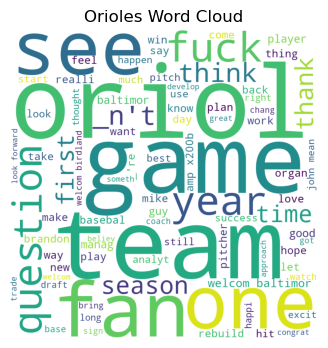

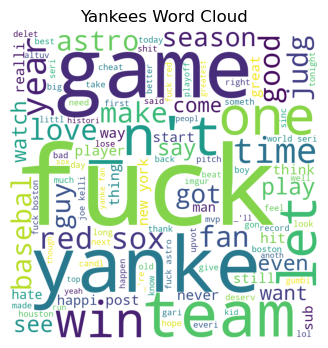

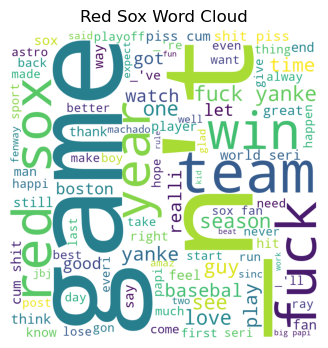

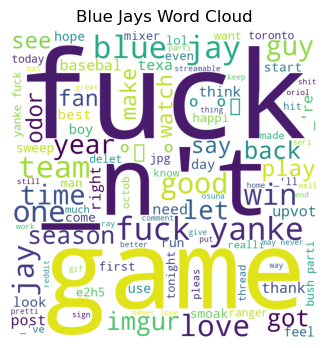

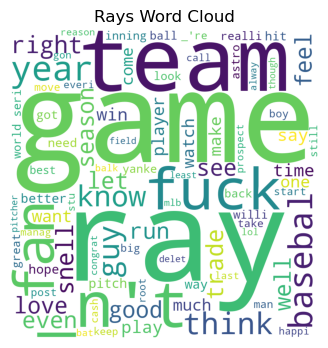

In [112]:
rdf = pd.read_csv('hw2_step2_reddit_posts.csv')
rdf['tokens'] = rdf['tokens'].apply(lambda tw: word_tokenize(tw))

phraser = Phrases(rdf['tokens'], min_count=5, delimiter= '_')
display(rdf)
rdf['tokens'] = rdf['tokens'].apply(lambda tw: phraser[tw])

stop_words = set(stopwords.words('english'))
rdf['tokens'] = rdf['tokens'].apply(lambda  tks: [tk for tk in tks if tk not in stop_words])
rdf['tokens'] = rdf['tokens'].apply(lambda tks: [tk for tk in tks if len(tk) > 3])


bal_posts = rdf.loc[rdf['team'] == 'BAL']
nyy_posts = rdf.loc[rdf['team'] == 'NYY']
bos_posts = rdf.loc[rdf['team'] == 'BOS']
tor_posts = rdf.loc[rdf['team'] == 'TOR']
tb_posts = rdf.loc[rdf['team'] == 'TB']








# Generate word cloud for BAL team
words_bal = []
for doc in bal_posts['tokens']:
	words_bal.extend(doc)

wordcloud_text_bal = ' '.join(words_bal)
wordcloud_bal = WordCloud(width=800, height=800,
						  background_color='white',
						  min_font_size=20
						  ).generate(wordcloud_text_bal)
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud_bal)
plt.axis('off')
plt.title('Orioles Word Cloud')
plt.show()

# Generate word cloud for NYY team
words_nyy = []
for doc in nyy_posts['tokens']:
	words_nyy.extend(doc)

wordcloud_text_nyy = ' '.join(words_nyy)
wordcloud_nyy = WordCloud(width=800, height=800,
						  background_color='white',
						  min_font_size=20
						  ).generate(wordcloud_text_nyy)
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud_nyy)
plt.axis('off')
plt.title('Yankees Word Cloud')
plt.show()

# Generate word cloud for BOS team
words_bos = []
for doc in bos_posts['tokens']:
	words_bos.extend(doc)

wordcloud_text_bos = ' '.join(words_bos)
wordcloud_bos = WordCloud(width=800, height=800,
						  background_color='white',
						  min_font_size=20
						  ).generate(wordcloud_text_bos)
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud_bos)
plt.axis('off')
plt.title('Red Sox Word Cloud')
plt.show()

# Generate word cloud for TOR team
words_tor = []
for doc in tor_posts['tokens']:
	words_tor.extend(doc)

wordcloud_text_tor = ' '.join(words_tor)
wordcloud_tor = WordCloud(width=800, height=800,
						  background_color='white',
						  min_font_size=20
						  ).generate(wordcloud_text_tor)
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud_tor)
plt.axis('off')
plt.title('Blue Jays Word Cloud')
plt.show()

# Generate word cloud for TB team
words_tb = []
for doc in tb_posts['tokens']:
	words_tb.extend(doc)

wordcloud_text_tb = ' '.join(words_tb)
wordcloud_tb = WordCloud(width=800, height=800,
						 background_color='white',
						 min_font_size=20
						 ).generate(wordcloud_text_tb)
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud_tb)
plt.axis('off')
plt.title('Rays Word Cloud')
plt.show()